<a href="https://colab.research.google.com/github/HadleyThomas/Final_Year_Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-cdft9e3z
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-cdft9e3z
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264331 sha256=0fd31ba8cd8116c873cb112d92e099c915540d6528bc338c089d87e06f3aa3bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhxex6re/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4
Cloning into 'vision'...
remote: Enumerating objects: 139684, done.
remote: Counting objects: 100% (5901/5901), done.
remote: Compressing objects: 100% (689/689), done.
remote: Total 139684 (delta 5406), reused 5619 (delta 5187), pack-reused 133783
Receiving objects: 100% (139684/139684), 273.21 MiB | 25.85 MiB/s,

In [2]:
! pip install neptune-client

     |████████████████████████████████| 316 kB 5.3 MB/s 
     |████████████████████████████████| 829 kB 35.3 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 181 kB 8.8 MB/s 
     |████████████████████████████████| 132 kB 27.0 MB/s 
     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 8.7 MB 34.3 MB/s 
     |████████████████████████████████| 138 kB 45.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 127 kB 48.5 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 130 kB 48.5 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.2-py2.py3-none-any.whl size=566337 sha256=5d09e378e54610fb2abb6f475b3a1526aa434614c9fdf09eef17ef3af7efeea3
  Stored in directory: /root/.cache/pip/wheels/6f/e9/85/964258b089a9890c505f5024f049fd

In [3]:
import neptune.new as neptune
from getpass import getpass
run = neptune.init(
    project="hadley/MEng",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NWNlN2Q2MS05N2JjLTRhZTQtYjRlYi0yMjU0OTg2NmQ0ZmYifQ==",
) 

https://app.neptune.ai/hadley/MEng/e/MEN-48
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [14]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class test_dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "/content/drive/MyDrive/final_uni_project/images-200"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "/content/drive/MyDrive/final_uni_project/masks-200"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "/content/drive/MyDrive/final_uni_project/images-200", self.imgs[idx])
        mask_path = os.path.join(self.root, "/content/drive/MyDrive/final_uni_project/masks-200", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.alexnet(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [18]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = test_dataset('/content/drive/MyDrive/final_uni_project', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
# use our dataset and defined transformations
dataset = test_dataset('/content/drive/MyDrive/final_uni_project', get_transform(train=True))
dataset_test = test_dataset('/content/drive/MyDrive/final_uni_project', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and tree
num_classes = 2

# get the model using our helper function
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [22]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    history = evaluate(model, data_loader_test, device=device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/67]  eta: 0:02:31  lr: 0.000081  loss: 0.8747 (0.8747)  loss_classifier: 0.5922 (0.5922)  loss_box_reg: 0.1435 (0.1435)  loss_objectness: 0.1264 (0.1264)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 2.2647  data: 1.0544  max mem: 2124
Epoch: [0]  [10/67]  eta: 0:01:12  lr: 0.000837  loss: 0.7590 (0.7617)  loss_classifier: 0.4186 (0.4660)  loss_box_reg: 0.1435 (0.1670)  loss_objectness: 0.0886 (0.1175)  loss_rpn_box_reg: 0.0126 (0.0112)  time: 1.2663  data: 0.1076  max mem: 2396
Epoch: [0]  [20/67]  eta: 0:00:57  lr: 0.001594  loss: 0.5792 (0.6536)  loss_classifier: 0.2548 (0.3470)  loss_box_reg: 0.1901 (0.1984)  loss_objectness: 0.0619 (0.0956)  loss_rpn_box_reg: 0.0110 (0.0126)  time: 1.1700  data: 0.0140  max mem: 2396
Epoch: [0]  [30/67]  eta: 0:00:44  lr: 0.002351  loss: 0.4974 (0.5815)  loss_classifier: 0.2130 (0.2905)  loss_box_reg: 0.2106 (0.2056)  loss_objectness: 0.0342 (0.0741)  loss_rpn_box_reg: 0.0095 (0.0113)  time: 1.1722  data: 0.0149  max mem: 2396
Epoch: [

In [24]:
predictions[0]

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
 'labels': tensor([], dtype=torch.int64),
 'scores': tensor([], grad_fn=<IndexBackward0>)}

In [25]:
torch.save(model.state_dict(), '/content/drive/MyDrive/final_uni_project/ResNet50-AlexNet-200-weights.pth')

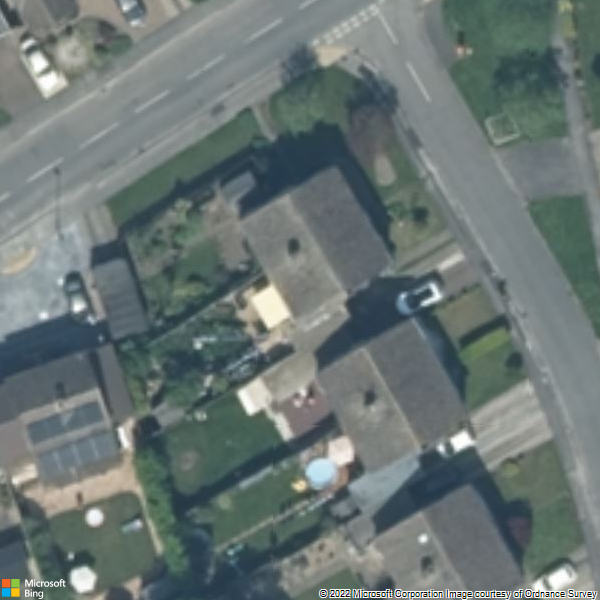

In [26]:
# pick one image from the test set
img, _ = dataset_test[8]
# put the model in evaluation 
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
import random

image_array = []
area_array =[]
colour_array =[]
for i in range(len(prediction[0]['masks'])):
  pic = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
  ret, pic1 = cv2.threshold(pic, 200, 255, cv2.THRESH_BINARY)
  occurrences = pic1 == 255
  total = occurrences.sum()
  area_array.append(total)
  output_pic = Image.fromarray(pic1)
  output_pic_p = output_pic.convert("RGB")
  image_array.append(output_pic_p)


width = 600 
height = 600

for k in range (len(prediction[0]['masks'])):
  img = image_array[k]
  R = random.randint(20,255)
  G = random.randint(20,255)
  B = random.randint(20,255)
  colour_array.append((R,G,B))
  for i in range(0,width):# process all pixels
      for j in range(0,height):
          data = img.getpixel((i,j))
          if (data[0]==255 and data[1]==255 and data[2]==255):
              img.putpixel((i,j),(R,G,B))



final_image = np.array(image_array[0])
for c in range(len(image_array)):
  add_image = True
  img = image_array[c]
  img_array_format = np.array(img)
  for i in range(0,width):# process all pixels
      for j in range(0,height):
          data = img_array_format[i,j]
          data_final = final_image[i,j]
          if (data[0]!=0):
            #print(str(data[0])+' '+str(data_final[0]))
            if(data_final[0]!=0):
              add_image = False
              print("NO ADD")
              break
      else:
          continue  
      break   
  
  if (add_image == True):
    final_image += np.array(image_array[c])
Image.fromarray(final_image)

In [28]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/hadley/MEng/e/MEN-48
